In [40]:
import os
from glob import glob
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

In [41]:
risultati = [y for x in os.walk("final_joined_result/") for y in glob(os.path.join(x[0], '*.csv'))]
risultati[:5]

['final_joined_result\\2d-10c_y.zip CLTree.csv',
 'final_joined_result\\2d-10c_y.zip kmodes.csv',
 'final_joined_result\\2d-10c_y.zip pyc_agglomerativeClust.csv',
 'final_joined_result\\2d-10c_y.zip pyc_xmeans.csv',
 'final_joined_result\\2d-10c_y.zip skl_agglomerativeClust.csv']

In [42]:
risultati_groupby_alg = dict()
risultati_groupby_dataset = dict()

for filename in risultati:
    alg = filename.split(" ")[-1][:-4]
    dataset = filename.split(" ")[0].split("\\")[-1][:-4]
    
    if alg not in risultati_groupby_alg:
        risultati_groupby_alg[alg] = []
    if dataset not in risultati_groupby_dataset:
        risultati_groupby_dataset[dataset] = []
    
    risultati_groupby_alg[alg].append(filename)
    risultati_groupby_dataset[dataset].append(filename)

In [43]:
res_values_uns = ["time", "silhouette", "calinski_harabasz", "davies_bouldin"]
res_values_sup = ["r_score", "adj_rand", "mut_info_score", "adj_mutual_info_score", "norm_mutual_info_score",
                                 "homog_score", "complete_score", "v_msr_score", "fwlks_mallows_score"]
res_values_all = res_values_uns + res_values_sup

In [44]:
df = pd.DataFrame()
lista = []

datasets = set()
algorithms = set()

for filename in risultati:
    alg = filename.split(" ")[-1][:-4]
    dataset = filename.split(" ")[0].split("\\")[-1][:-4].replace(".zip", "").replace("-", "")
    
    skip = False
    for d in ["german_credit_y", "ionosphere_y", "home", "iris", "wdbc_y", "vehicle_y", "titanic_y", "wine"]:
        if d in dataset:
            skip = True
    if skip: continue
        
    
    datasets.add(dataset)
    algorithms.add(alg)
    
    lista.append(pd.read_csv(filename))
    
    lista[-1]["alg"] = alg
    if "wine" in dataset:
        lista[-1]["dataset"] = "wine"
    elif "home" in dataset:
        lista[-1]["dataset"] = "home"
    else:
        lista[-1]["dataset"] = dataset.split("_y")[0]+"_y"
    
df = pd.concat(lista)

df.columns

Index(['min_nr_instances', 'min_y', 'min_rd', 'time', 'silhouette',
       'calinski_harabasz', 'davies_bouldin', 'r_score', 'adj_rand',
       'mut_info_score', 'adj_mutual_info_score', 'norm_mutual_info_score',
       'homog_score', 'complete_score', 'v_msr_score', 'fwlks_mallows_score',
       'alg', 'dataset', 'n_clusters', 'max_iter', 'init', 'n_init', 'verbose',
       'random_state', 'n_jobs', 'number_clusters', 'amount_initial_centers',
       'kmax', 'metric', 'linkage', 'threshold', 'branching_factor', 'eps',
       'min_samples', 'algorithm', 'max_eps', 'tol', 'copy',
       'bisecting_strategy', 'labels_as_tree_leaves', 'criterion', 'splitter',
       'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf',
       'max_features', 'max_leaf_nodes', 'min_impurity_decrease',
       'class_weight', 'ccp_alpha', 'max_depth', 'max_nbr_clusters',
       'max_nbr_values', 'max_nbr_values_cat', 'bic_eps', 'metric_con',
       'metric_cat', 'criteria_clf', 'criteria_reg',

In [45]:
lista_continui = ['datasets/syntetic/2d-3c-no123_y.zip', 'datasets/syntetic/s-set1_y.zip', 'datasets/syntetic/2d-20c-no0_y.zip', 'datasets/syntetic/triangle2_y.zip',
                  'datasets/syntetic/triangle1_y.zip', 'datasets/syntetic/cure-t0-2000n-2D_y.zip', 'datasets/syntetic/longsquare_y.zip', 'datasets/syntetic/aggregation_y.zip',
                  'datasets/syntetic/2d-4c-no9_y.zip', 'datasets/syntetic/2d-d31_y.zip', 'datasets/syntetic/cure-t2-4k_y.zip', 'datasets/syntetic/zelnik6_y.zip',
                  'datasets/syntetic/2d-10c_y.zip', 'datasets/syntetic/2d-4c_y.zip', 'datasets/syntetic/zelnik5_y.zip', 'datasets/syntetic/cure-t1-2000n-2D_y.zip',
                  'datasets/syntetic/s-set2_y.zip', 'datasets/syntetic/tetra_y.zip']

lista_continui = list(map(lambda x: x.split("/")[-1][:-4].replace("-", ""), lista_continui[:10]))

lista_continui

['2d3cno123_y',
 'sset1_y',
 '2d20cno0_y',
 'triangle2_y',
 'triangle1_y',
 'curet02000n2D_y',
 'longsquare_y',
 'aggregation_y',
 '2d4cno9_y',
 '2dd31_y']

In [46]:
df = df[df.dataset.isin(lista_continui)].copy(deep=True)


In [47]:
df.dataset.unique()

array(['2d20cno0_y', '2d3cno123_y', '2d4cno9_y', '2dd31_y',
       'aggregation_y', 'curet02000n2D_y', 'longsquare_y', 'sset1_y',
       'triangle1_y', 'triangle2_y'], dtype=object)

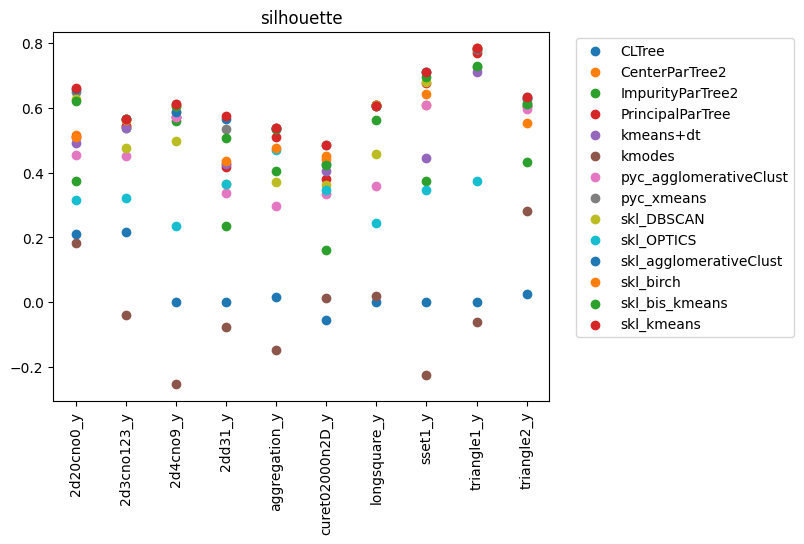

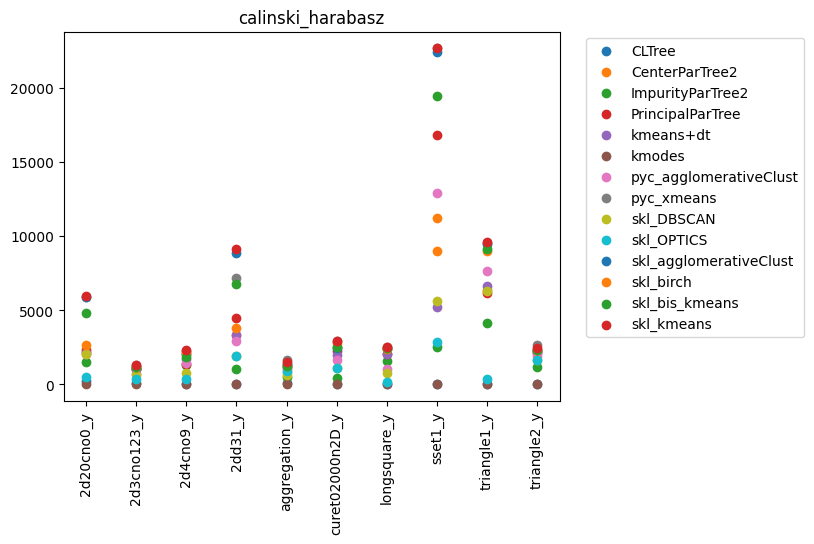

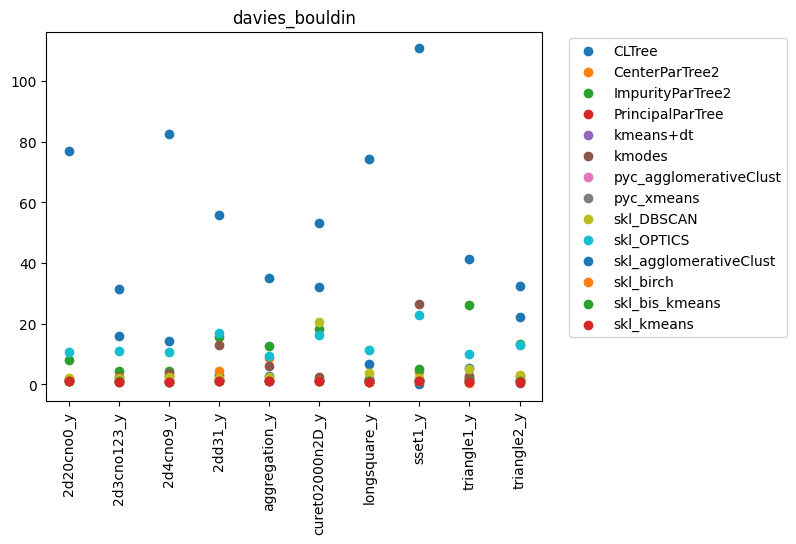

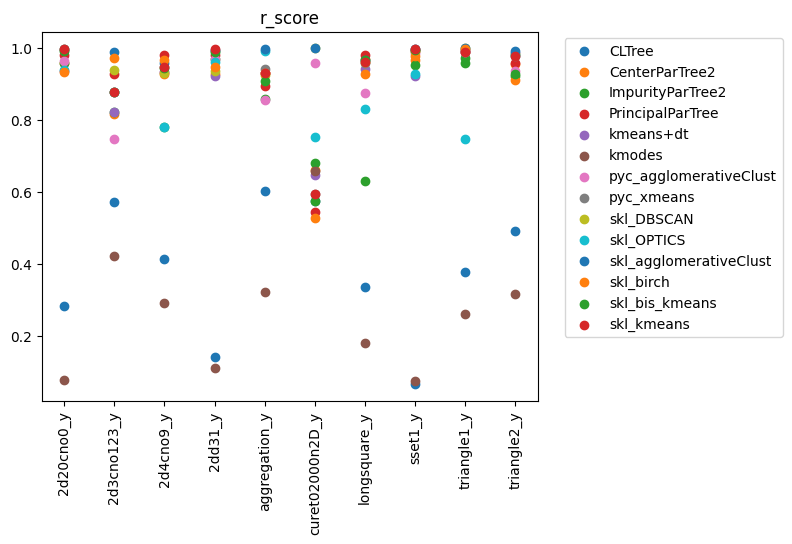

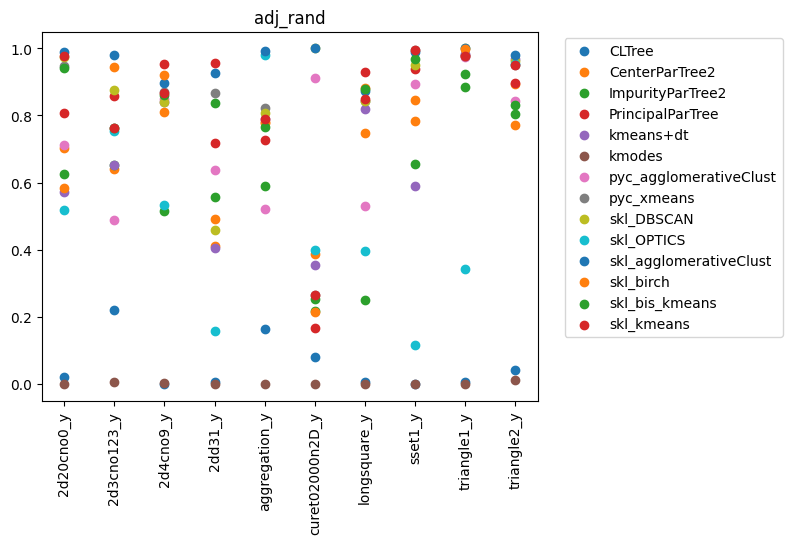

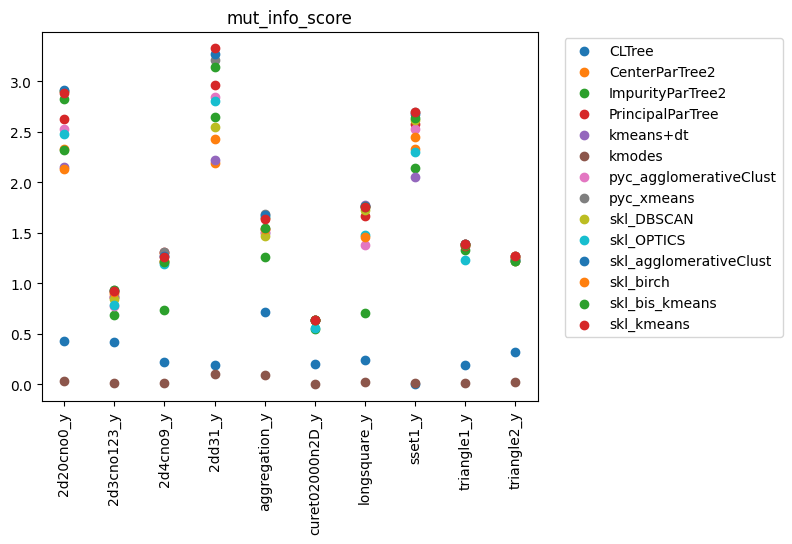

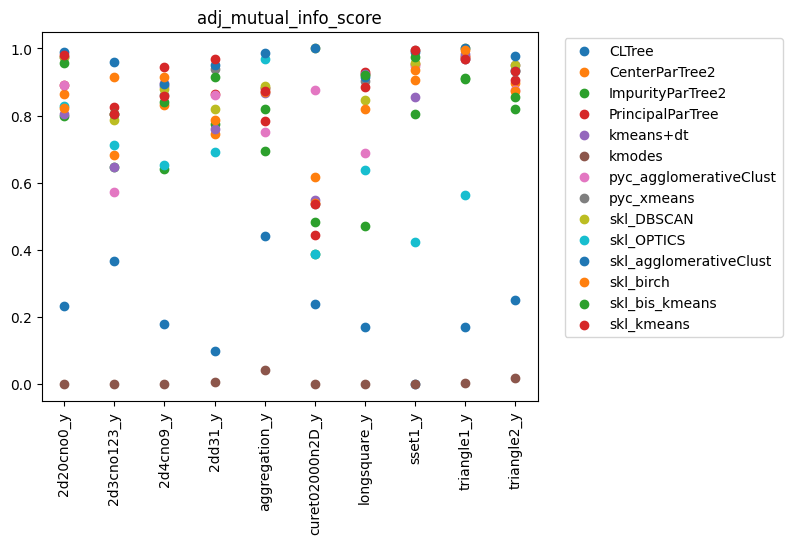

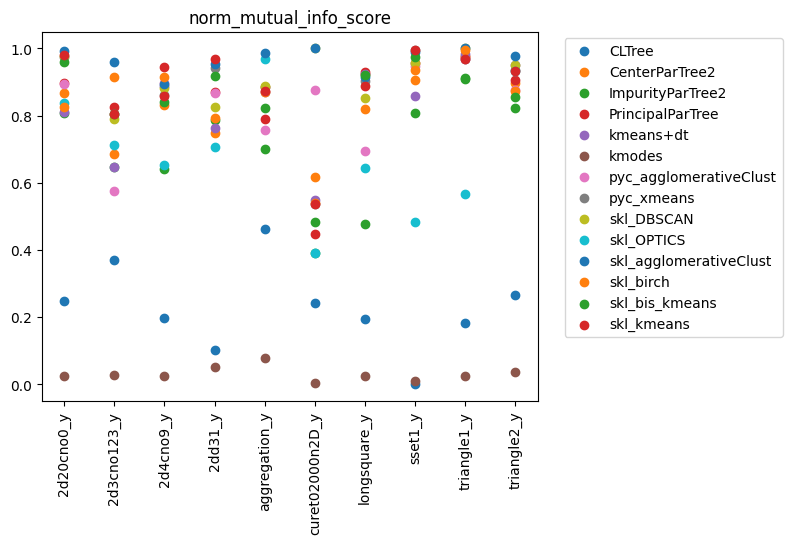

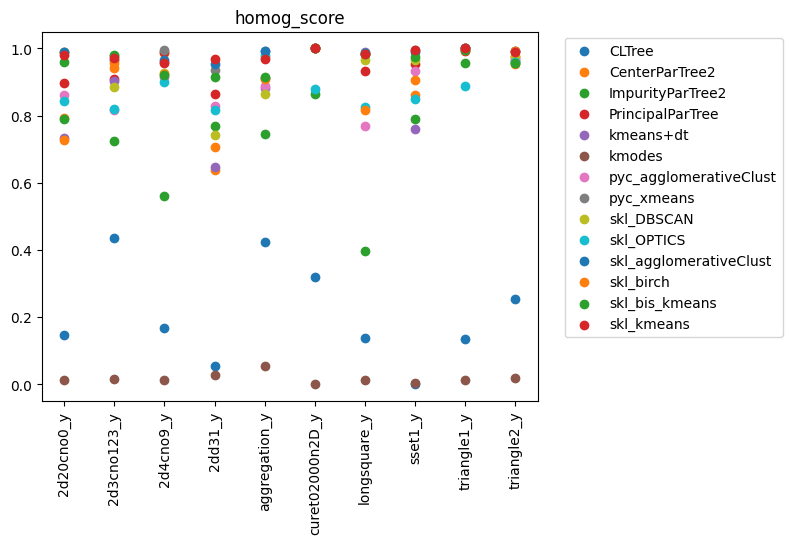

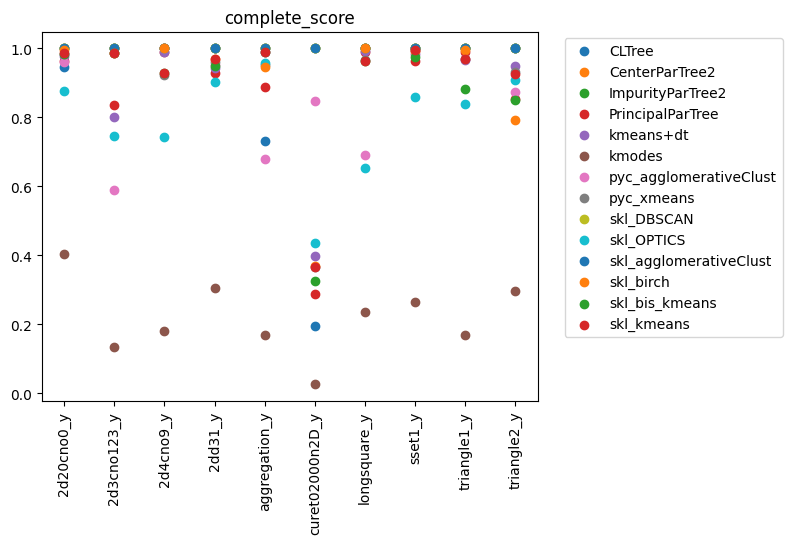

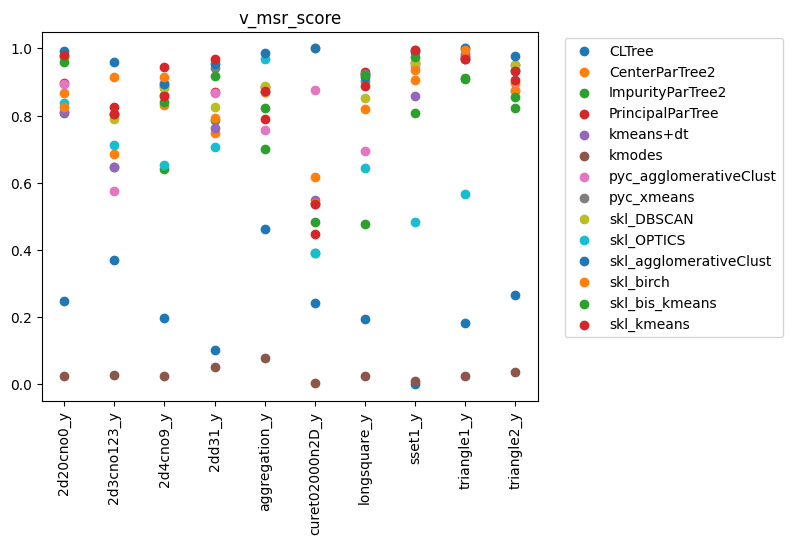

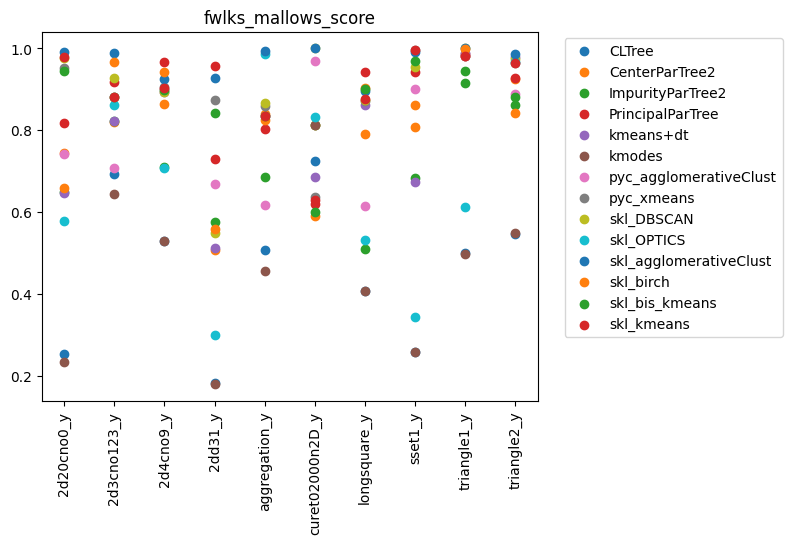

In [48]:
for col in res_values_all:
    if col == "time":
        continue

    df_plot = df.groupby(by=["dataset", "alg"])[[col, "time"]].max().reset_index()
    
    #df_plot = df_plot[df_plot.alg.isin(algoritmi_grafico)]

    for alg in df_plot.alg.unique():
        plt.scatter(df_plot[df_plot.alg == alg].dataset, 
                    df_plot[df_plot.alg == alg][col], 
                    label=alg, 
                    #s=df_plot[df_plot.alg == alg].time
                   )

    plt.title(col)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    plt.xticks(rotation=90)

    plt.show()

In [49]:
df.head()

,min_nr_instances,min_y,min_rd,time,silhouette,calinski_harabasz,davies_bouldin,r_score,adj_rand,mut_info_score,...,max_nbr_values,max_nbr_values_cat,bic_eps,metric_con,metric_cat,criteria_clf,criteria_reg,n_components,oblique_splits,max_oblique_features
0,NaN,NaN,NaN,3.634057,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,100.0,0.0,cos,jaccard,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,3.627831,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,100.0,0.1,cos,jaccard,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,3.561942,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,100.0,0.2,cos,jaccard,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,3.647791,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,20.0,0.0,cos,jaccard,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,3.625458,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,20.0,0.1,cos,jaccard,NaN,NaN,NaN,NaN,NaN


In [50]:
df.sort_values(['dataset', 'alg', 'silhouette'], ascending=False).groupby(['dataset', 'alg']).nth(0)

min_nr_instances  min_y  min_rd      time  \
dataset     alg                                                                 
2d20cno0_y  CLTree                               2.0    3.0    10.0  9.296658   
            CenterParTree2                       NaN    NaN     NaN  4.334164   
            ImpurityParTree2                     NaN    NaN     NaN  0.720954   
            PrincipalParTree                     NaN    NaN     NaN  0.100259   
            kmeans+dt                            NaN    NaN     NaN  0.062153   
...                                              ...    ...     ...       ...   
triangle2_y skl_OPTICS                           NaN    NaN     NaN  1.797186   
            skl_agglomerativeClust               NaN    NaN     NaN  0.012339   
            skl_birch                            NaN    NaN     NaN  0.016998   
            skl_bis_kmeans                       NaN    NaN     NaN  0.083615   
            skl_kmeans                           NaN    NaN     NaN  0.077580   

                                    silhouette  calinski_harabasz  \
dataset     alg                                                     
2d20cno0_y  CLTree                      0.2091           250.9050   
            CenterParTree2              0.5153          2379.6346   
            ImpurityParTree2            0.3746           916.8645   
            PrincipalParTree            0.5090          2281.2074   
            kmeans+dt                   0.4926          2080.6172   
...                                        ...                ...   
triangle2_y skl_OPTICS                  0.6117          1660.7611   
            skl_agglomerativeClust      0.6299          2268.1165   
            skl_birch                   0.5539          2305.0320   
            skl_bis_kmeans              0.6112          2102.3592   
            skl_kmeans                  0.6335          2360.4664   

                                    davies_bouldin  r_score  adj_rand  \
dataset     alg                                                         
2d20cno0_y  CLTree                          0.6860   0.1780    0.0152   
            CenterParTree2                  0.7447   0.9600    0.7024   
            ImpurityParTree2                1.1121   0.5020    0.0867   
            PrincipalParTree                0.7378   0.9799    0.8068   
            kmeans+dt                       0.6974   0.7804    0.2610   
...                                            ...      ...       ...   
triangle2_y skl_OPTICS                      1.3132   0.9808    0.9535   
            skl_agglomerativeClust          0.4839   0.9917    0.9801   
            skl_birch                       0.6727   0.9124    0.7724   
            skl_bis_kmeans                  0.5015   0.9296    0.8308   
            skl_kmeans                      0.4926   0.9790    0.9497   

                                    mut_info_score  ...  max_nbr_values  \
dataset     alg                                     ...                   
2d20cno0_y  CLTree                          0.2314  ...             NaN   
            CenterParTree2                  2.3316  ...          1000.0   
            ImpurityParTree2                0.6100  ...          1000.0   
            PrincipalParTree                2.6320  ...          1000.0   
            kmeans+dt                       1.2995  ...             NaN   
...                                            ...  ...             ...   
triangle2_y skl_OPTICS                      1.2287  ...             NaN   
            skl_agglomerativeClust          1.2486  ...             NaN   
            skl_birch                       1.2667  ...             NaN   
            skl_bis_kmeans                  1.1002  ...             NaN   
            skl_kmeans                      1.1993  ...             NaN   

                                    max_nbr_values_cat  bic_eps  metric_con  \
dataset     alg                                                               


In [51]:
df.groupby(['dataset', 'alg']).filter(lambda x: True)#.nth(100)  #[['dataset', 'alg', 'silhouette']]

,min_nr_instances,min_y,min_rd,time,silhouette,calinski_harabasz,davies_bouldin,r_score,adj_rand,mut_info_score,...,max_nbr_values,max_nbr_values_cat,bic_eps,metric_con,metric_cat,criteria_clf,criteria_reg,n_components,oblique_splits,max_oblique_features
0,NaN,NaN,NaN,3.634057,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,100.0,0.0,cos,jaccard,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,3.627831,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,100.0,0.1,cos,jaccard,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,3.561942,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,100.0,0.2,cos,jaccard,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,3.647791,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,20.0,0.0,cos,jaccard,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,3.625458,0.4981,2208.1437,0.8111,0.9405,0.6087,2.1478,...,1000.0,20.0,0.1,cos,jaccard,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,NaN,NaN,NaN,0.086432,0.4047,1917.9822,1.0280,0.8469,0.5756,1.2339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,0.102964,0.4047,1917.9822,1.0280,0.8469,0.5756,1.2339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.092436,0.4047,1917.9822,1.0280,0.8469,0.5756,1.2339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,0.087744,0.4047,1917.9822,1.0280,0.8469,0.5756,1.2339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df.groupby(['dataset', 'alg'])['silhouette'].transform(max)

0     0.5153
1     0.5153
2     0.5153
3     0.5153
4     0.5153
       ...  
7     0.6261
8     0.6261
9     0.6261
10    0.6261
11    0.6261
Name: silhouette, Length: 570069, dtype: float64

In [53]:
idx = df.groupby(['dataset', 'alg'])['silhouette'].transform(max) == df['silhouette']

In [54]:
df.loc[idx][['dataset', 'alg', 'silhouette']]

,dataset,alg,silhouette
108,2d20cno0_y,CenterParTree2,0.5153
109,2d20cno0_y,CenterParTree2,0.5153
110,2d20cno0_y,CenterParTree2,0.5153
111,2d20cno0_y,CenterParTree2,0.5153
112,2d20cno0_y,CenterParTree2,0.5153
...,...,...,...
7,triangle2_y,kmeans+dt,0.6261
8,triangle2_y,kmeans+dt,0.6261
9,triangle2_y,kmeans+dt,0.6261
10,triangle2_y,kmeans+dt,0.6261


In [55]:
df.dataset.unique()

array(['2d20cno0_y', '2d3cno123_y', '2d4cno9_y', '2dd31_y',
       'aggregation_y', 'curet02000n2D_y', 'longsquare_y', 'sset1_y',
       'triangle1_y', 'triangle2_y'], dtype=object)

In [64]:
order = "norm_mutual_info_score"

In [65]:
df_subset = df.sort_values(['dataset', 'alg', order], ascending=False).groupby(['dataset', 'alg']).nth(0).reset_index()

df_subset[res_values_sup]

,r_score,adj_rand,mut_info_score,adj_mutual_info_score,norm_mutual_info_score,homog_score,complete_score,v_msr_score,fwlks_mallows_score
0,0.2833,0.0221,0.4326,0.2318,0.2471,0.1472,0.7686,0.2471,0.2435
1,0.9600,0.7024,2.3316,0.8626,0.8663,0.7935,0.9537,0.8663,0.7449
2,0.9583,0.6249,2.3234,0.7977,0.8063,0.7907,0.8226,0.8063,0.6489
3,0.9799,0.8068,2.6320,0.8922,0.8970,0.8958,0.8982,0.8970,0.8175
4,0.9325,0.5707,2.0993,0.8050,0.8105,0.7145,0.9364,0.8105,0.6453
...,...,...,...,...,...,...,...,...,...
135,0.9808,0.9535,1.2287,0.9335,0.9338,0.9600,0.9090,0.9338,0.9674
136,0.9917,0.9801,1.2486,0.9762,0.9763,0.9756,0.9770,0.9763,0.9861
137,0.9124,0.7724,1.2667,0.8722,0.8729,0.9897,0.7808,0.8729,0.8410
138,0.9296,0.8308,1.1002,0.8540,0.8545,0.8596,0.8494,0.8545,0.8808


In [66]:
df_subset["rank_per_dataset"] = df_subset.groupby("dataset")[order].rank(ascending=False).astype(int)

df_subset.sort_values(["dataset", "rank_per_dataset"])[["rank_per_dataset", order, "alg", "dataset"]]

,rank_per_dataset,norm_mutual_info_score,alg,dataset
10,1,0.9908,skl_agglomerativeClust,2d20cno0_y
13,2,0.9815,skl_kmeans,2d20cno0_y
8,3,0.9764,skl_DBSCAN,2d20cno0_y
7,4,0.9741,pyc_xmeans,2d20cno0_y
12,5,0.9593,skl_bis_kmeans,2d20cno0_y
...,...,...,...,...
137,10,0.8729,skl_birch,triangle2_y
138,11,0.8545,skl_bis_kmeans,triangle2_y
128,12,0.8217,ImpurityParTree2,triangle2_y
126,13,0.2651,CLTree,triangle2_y


In [67]:
df_agg = df_subset.groupby("alg")[res_values_all].agg(["mean", "std"])

df_agg.head()

time            silhouette           calinski_harabasz  \
                       mean        std       mean       std              mean   
alg                                                                             
CLTree            23.602177  35.333141   -0.33335  0.284189          30.10812   
CenterParTree2     6.211796   9.873339    0.50146  0.126783        2980.67793   
ImpurityParTree2   4.300070   6.532973    0.25144  0.180692        1179.42609   
PrincipalParTree   0.073413   0.048859    0.48131  0.154167        3673.78556   
kmeans+dt          0.171787   0.306859    0.47895  0.130645        2247.30713   

                              davies_bouldin             r_score            \
                          std           mean        std     mean       std   
alg                                                                          
CLTree              25.525194       10.56447  14.389099  0.38441  0.181687   
CenterParTree2    2638.229510        0.66135   0.134763  0.90848  0.103346   
ImpurityParTree2   893.390987        1.26816   0.586841  0.82883  0.173739   
PrincipalParTree  4882.781167        0.80712   0.267703  0.91453  0.164448   
kmeans+dt         1521.697901        0.75721   0.246596  0.89349  0.131020   

                  ... norm_mutual_info_score           homog_score            \
                  ...                   mean       std        mean       std   
alg               ...                                                          
CLTree            ...                0.22640  0.128471     0.18957  0.125796   
CenterParTree2    ...                0.83391  0.114466     0.89723  0.110590   
ImpurityParTree2  ...                0.69900  0.163796     0.72467  0.192309   
PrincipalParTree  ...                0.85382  0.154112     0.92420  0.060972   
kmeans+dt         ...                0.82410  0.136939     0.81705  0.151980   

                 complete_score           v_msr_score            \
                           mean       std        mean       std   
alg                                                               
CLTree                  0.50082  0.277145     0.22640  0.128471   
CenterParTree2          0.80693  0.174407     0.83391  0.114466   
ImpurityParTree2        0.73360  0.177445     0.69900  0.163796   
PrincipalParTree        0.82514  0.201767     0.85382  0.154112   
kmeans+dt               0.87743  0.184984     0.82410  0.136939   

                 fwlks_mallows_score            
                                mean       std  
alg                                             
CLTree                       0.41081  0.164053  
CenterParTree2               0.79634  0.139340  
ImpurityParTree2             0.68367  0.161399  
PrincipalParTree             0.83539  0.176555  
kmeans+dt                    0.77680  0.169676  

[5 rows x 26 columns]

In [68]:
df_subset.groupby("alg")[["rank_per_dataset"]].agg(
    total=("rank_per_dataset", len),
    rank_list=("rank_per_dataset", lambda x: len(x[x == 1]))
)

,total,rank_list
alg,,
CLTree,10,0
CenterParTree2,10,0
ImpurityParTree2,10,0
PrincipalParTree,10,2
kmeans+dt,10,0
kmodes,10,0
pyc_agglomerativeClust,10,0
pyc_xmeans,10,1
skl_DBSCAN,10,2


In [69]:
dfs_win = []

metriche = dict([#Ascending?
    ('silhouette', False), #max
    ('time', True), #min
    ('calinski_harabasz', False),
    ('davies_bouldin', True),
    ('r_score', False),
    ('adj_rand', False),
    ('mut_info_score', False),
    ('adj_mutual_info_score', False),
    ('norm_mutual_info_score', False),
    ('homog_score', True),
    ('complete_score', False),
    ('v_msr_score', False),
    ('fwlks_mallows_score', False)
])

def getWin(metrica):
    ascending = metriche[metrica]
    df_tmp = df_subset[["alg", "dataset", metrica]].copy()
    df_tmp["rank"] = df_subset.groupby("dataset")[metrica].rank(ascending=ascending, na_option="top" if ascending else "bottom").astype(int)

    
    dfs_win.append(df_tmp)
    
    #print(metrica)
    #print(df_tmp.sort_values(["dataset", metrica], ascending=ascending)[[metrica, "rank"]].head())
    
    return df_tmp.groupby("alg")[["rank"]].agg(
        c=("rank", len),
        win=("rank", lambda x: len(x[x == 1])),
        rank_mean=("rank", np.mean)
    )

In [70]:
for metrica in res_values_all:
    df_tmp = getWin(metrica)
    df_agg[(metrica, "win")] = df_tmp.win
    df_agg[(metrica, "count")] = df_tmp.c
    df_agg[(metrica, "rank_mean")] = df_tmp.rank_mean

df_agg[df_agg.columns.sort_values()]

adj_mutual_info_score                                   \
                                       count     mean rank_mean       std win   
alg                                                                             
CLTree                                    10  0.21488      13.1  0.125435   0   
CenterParTree2                            10  0.83223       7.0  0.114940   0   
ImpurityParTree2                          10  0.69498      11.2  0.163698   0   
PrincipalParTree                          10  0.85180       5.5  0.154559   2   
kmeans+dt                                 10  0.82251       6.8  0.137407   0   
kmodes                                    10  0.00663      13.9  0.013905   0   
pyc_agglomerativeClust                    10  0.83283       7.7  0.124266   0   
pyc_xmeans                                10  0.87932       4.9  0.133996   1   
skl_DBSCAN                                10  0.91016       4.4  0.076434   2   
skl_OPTICS                                10  0.66282       9.3  0.223754   0   
skl_agglomerativeClust                    10  0.96620       2.0  0.036750   6   
skl_birch                                 10  0.84706       6.5  0.124643   0   
skl_bis_kmeans                            10  0.84747       7.1  0.140403   0   
skl_kmeans                                10  0.88002       5.1  0.136148   2   

                       adj_rand                                   ...  time  \
                          count     mean rank_mean       std win  ... count   
alg                                                               ...         
CLTree                       10  0.05237      13.2  0.078195   0  ...    10   
CenterParTree2               10  0.71603       7.8  0.205520   0  ...    10   
ImpurityParTree2             10  0.56739      10.3  0.238176   0  ...    10   
PrincipalParTree             10  0.78394       5.6  0.256206   2  ...    10   
kmeans+dt                    10  0.68574       7.5  0.242320   0  ...    10   
kmodes                       10 -0.00085      13.8  0.008882   0  ...    10   
pyc_agglomerativeClust       10  0.72816       8.3  0.188582   0  ...    10   
pyc_xmeans                   10  0.82031       4.8  0.229783   1  ...    10   
skl_DBSCAN                   10  0.87154       4.4  0.161291   2  ...    10   
skl_OPTICS                   10  0.50456       8.8  0.317797   0  ...    10   
skl_agglomerativeClust       10  0.96268       1.8  0.046317   6  ...    10   
skl_birch                    10  0.72948       6.9  0.239547   0  ...    10   
skl_bis_kmeans               10  0.78845       6.7  0.230932   0  ...    10   
skl_kmeans                   10  0.83289       4.6  0.235497   2  ...    10   

                                                           v_msr_score  \
                             mean rank_mean        std win       count   
alg                                                                      
CLTree                  23.602177      13.8  35.333141   0          10   
CenterParTree2           6.211796      11.8   9.873339   0          10   
ImpurityParTree2         4.300070      11.9   6.532973   0          10   
PrincipalParTree         0.073413       5.5   0.048859   0          10   
kmeans+dt                0.171787       6.3   0.306859   0          10   
kmodes                   0.403637       9.0   0.404855   0          10   
pyc_agglomerativeClust   7.517908      10.7  17.129233   0          10   
pyc_xmeans               0.024703       2.6   0.022432   1          10   
skl_DBSCAN               0.011614       1.9   0.004148   6          10   
skl_OPTICS               3.366132      11.8   3.207686   0          10   
skl_agglomerativeClust   0.056845       2.6   0.113502   3          10   
skl_birch                0.026751       3.3   0.022701   0          10   
skl_bis_kmeans           0.206003       7.5   0.283178   0          10   
skl_kmeans               0.156324       6.3   0.240050   0          10   

                                          

In [71]:
df_agg[df_agg.columns.sort_values()].to_csv(f"10 cont datasets ranked by {order}.csv")
df_agg[df_agg.columns.sort_values()].to_excel(f"10 cont datasets ranked by {order}.xlsx")